In [1]:
import pandas as pd
import numpy as np
import tables as tb
import os
import matplotlib.pyplot as plt
from mpl_interactions import ioff, panhandler, zoom_factory
from ipywidgets import interact, IntSlider
import ipywidgets as widgets
import sys
from datetime import datetime
from scipy.optimize import curve_fit
from lmfit import Model

In [26]:
RUN="14180"
# RUN="13850"

mode = "deconv"

In [3]:
file = f"../data/analysis/Run_{RUN}_Filtered.h5"
# file = f"../data/analysis/Run_{RUN}_FilteredRaw.h5"

# Load the data
data = pd.read_hdf(file, "data")
data_properties = pd.read_hdf(file, "data_properties")

# Convert 'event' columns to integers
data['event'] = data['event'].astype(int)
data_properties['event'] = data_properties['event'].astype(int)

# Get event_ids where 'x' or 'y' has NaN values
nan_event_ids = data_properties[data_properties['x'].isna()]['event'].values
nan_event_ids = np.append(nan_event_ids, data_properties[data_properties['y'].isna()]['event'].values)

# Filter out rows in data and data_properties based on the 'event' column
data_properties = data_properties[~data_properties['event'].isin(nan_event_ids)]
data = data[~data['event'].isin(nan_event_ids)]

# Check if there are still NaN values
print(data.isna().sum())
print(data_properties.isna().sum())
display(data)

display(data_properties)
print(len(data_properties.event.unique()))

event        0
ts_raw       0
pmt          0
pe_int       0
peak_time    0
noise_thr    0
ts           0
dtype: int64
event          0
S2_area        0
cath_area      0
ts_raw         0
deltaT         0
sigma          0
S2_amp         0
x              0
y              0
grass_peaks    0
nS1            0
ts             0
dtype: int64


,event,ts_raw,pmt,pe_int,peak_time,noise_thr,ts
0,27760,1.723015e+09,0,927.889920,1393.375,109.827369,2024-08-07 02:12:55.076
1,27760,1.723015e+09,0,829.009920,1396.225,109.827369,2024-08-07 02:12:55.076
2,27760,1.723015e+09,0,1916.689920,1400.800,109.827369,2024-08-07 02:12:55.076
3,27760,1.723015e+09,0,1685.969920,1424.500,109.827369,2024-08-07 02:12:55.076
4,27760,1.723015e+09,0,2147.409920,1498.625,109.827369,2024-08-07 02:12:55.076
...,...,...,...,...,...,...,...
51163,17010,1.723014e+09,59,1789.454222,1496.200,125.058941,2024-08-07 02:03:22.813
51164,17010,1.723014e+09,59,1377.628552,1530.075,125.058941,2024-08-07 02:03:22.813
51165,17010,1.723014e+09,59,659.778452,1558.625,125.058941,2024-08-07 02:03:22.813
51166,17010,1.723014e+09,59,1341.876190,1578.100,125.058941,2024-08-07 02:03:22.813


,event,S2_area,cath_area,ts_raw,deltaT,sigma,S2_amp,x,y,grass_peaks,nS1,ts
0,27760,3.620563e+08,8.506972e+05,1.723015e+09,91.375,3.288948,1.151331e+06,149.925,-371.075,0.0,1.0,2024-08-07 02:12:55.076
1,27767,3.720135e+08,2.093862e+06,1.723015e+09,682.400,5.186409,7.778402e+05,-204.725,106.975,0.0,1.0,2024-08-07 02:12:55.614
2,27774,5.119326e+08,1.409290e+06,1.723015e+09,-999.000,6.114938,8.962126e+05,26.525,-78.625,1.0,2.0,2024-08-07 02:12:55.943
3,27781,3.621512e+08,1.005992e+06,1.723015e+09,738.350,5.188740,7.415586e+05,-126.975,-31.975,0.0,1.0,2024-08-07 02:12:56.134
4,27788,3.657642e+08,1.595617e+06,1.723015e+09,782.750,5.694477,6.884924e+05,26.525,-325.425,1.0,1.0,2024-08-07 02:12:56.454
...,...,...,...,...,...,...,...,...,...,...,...,...
76,16982,4.712700e+08,8.121690e+05,1.723014e+09,20.125,2.259608,1.774150e+06,26.525,-340.975,1.0,1.0,2024-08-07 02:03:21.263
77,16989,4.910421e+08,9.090475e+05,1.723014e+09,383.925,4.716690,1.002240e+06,-50.225,-202.025,0.0,1.0,2024-08-07 02:03:21.857
78,16996,6.697731e+08,1.614886e+06,1.723014e+09,-999.000,6.487710,1.028014e+06,-281.475,14.175,1.0,3.0,2024-08-07 02:03:22.292
79,17003,5.637547e+08,1.186365e+06,1.723014e+09,802.300,6.657705,8.798408e+05,-173.625,230.375,0.0,1.0,2024-08-07 02:03:22.531


51659


In [4]:
# Rebin the x and y

# Define bin edges using np.linspace for x and y
x_bins = np.linspace(-500, 500, 10)  # 10 evenly spaced bins between -500 and 500
y_bins = np.linspace(-500, 500, 10)

# Bin the x and y columns
data_properties['x_bin'] = pd.cut(data_properties['x'], bins=x_bins, labels=False)  # Labels as index (0, 1, 2,...)
data_properties['y_bin'] = pd.cut(data_properties['y'], bins=y_bins, labels=False)

# Calculate bin centers
x_bin_centers = (x_bins[:-1] + x_bins[1:]) / 2  # Bin centers for x
y_bin_centers = (y_bins[:-1] + y_bins[1:]) / 2  # Bin centers for y

# Assign the bin centers as new columns
data_properties['x_bin_center'] = data_properties['x_bin'].map(lambda i: x_bin_centers[i] if pd.notna(i) else np.nan)
data_properties['y_bin_center'] = data_properties['y_bin'].map(lambda i: y_bin_centers[i] if pd.notna(i) else np.nan)

# Assign a unique bin ID for each (x_bin, y_bin) pair
data_properties['bin_id'] = data_properties['x_bin'].astype(str) + '_' + data_properties['y_bin'].astype(str)

display(data_properties)

,event,S2_area,cath_area,ts_raw,deltaT,sigma,S2_amp,x,y,grass_peaks,nS1,ts,x_bin,y_bin,x_bin_center,y_bin_center,bin_id
0,27760,3.620563e+08,8.506972e+05,1.723015e+09,91.375,3.288948,1.151331e+06,149.925,-371.075,0.0,1.0,2024-08-07 02:12:55.076,5,1,111.111111,-333.333333,5_1
1,27767,3.720135e+08,2.093862e+06,1.723015e+09,682.400,5.186409,7.778402e+05,-204.725,106.975,0.0,1.0,2024-08-07 02:12:55.614,2,5,-222.222222,111.111111,2_5
2,27774,5.119326e+08,1.409290e+06,1.723015e+09,-999.000,6.114938,8.962126e+05,26.525,-78.625,1.0,2.0,2024-08-07 02:12:55.943,4,3,0.000000,-111.111111,4_3
3,27781,3.621512e+08,1.005992e+06,1.723015e+09,738.350,5.188740,7.415586e+05,-126.975,-31.975,0.0,1.0,2024-08-07 02:12:56.134,3,4,-111.111111,0.000000,3_4
4,27788,3.657642e+08,1.595617e+06,1.723015e+09,782.750,5.694477,6.884924e+05,26.525,-325.425,1.0,1.0,2024-08-07 02:12:56.454,4,1,0.000000,-333.333333,4_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,16982,4.712700e+08,8.121690e+05,1.723014e+09,20.125,2.259608,1.774150e+06,26.525,-340.975,1.0,1.0,2024-08-07 02:03:21.263,4,1,0.000000,-333.333333,4_1
77,16989,4.910421e+08,9.090475e+05,1.723014e+09,383.925,4.716690,1.002240e+06,-50.225,-202.025,0.0,1.0,2024-08-07 02:03:21.857,4,2,0.000000,-222.222222,4_2
78,16996,6.697731e+08,1.614886e+06,1.723014e+09,-999.000,6.487710,1.028014e+06,-281.475,14.175,1.0,3.0,2024-08-07 02:03:22.292,1,4,-333.333333,0.000000,1_4
79,17003,5.637547e+08,1.186365e+06,1.723014e+09,802.300,6.657705,8.798408e+05,-173.625,230.375,0.0,1.0,2024-08-07 02:03:22.531,2,6,-222.222222,222.222222,2_6


In [24]:
print(len(nan_event_ids))

1194


Text(0.5, 1.0, 'RUN 14180')

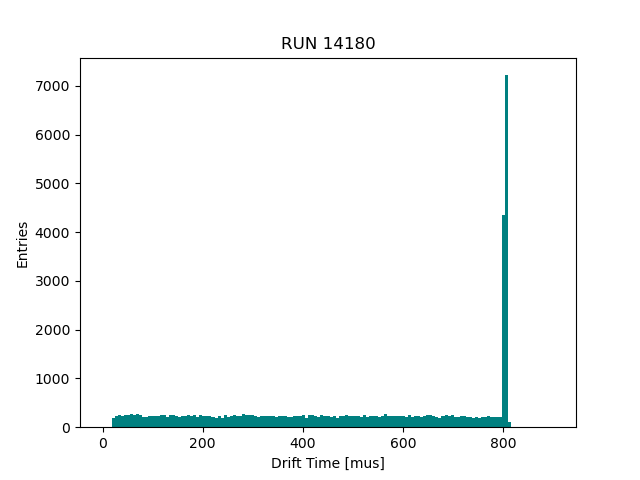

In [5]:
%matplotlib widget
plt.figure()

plt.hist(data_properties.deltaT, bins = np.linspace(0, 900, 150), color = "Teal");
plt.xlabel("Drift Time [mus]")
plt.ylabel("Entries")
plt.title(f"RUN {RUN}")


False


/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_84416/684025163.py:13: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_bad(color='white')  # Set masked values (zeros) to white


Text(0, 0.5, 'Y [mm]')

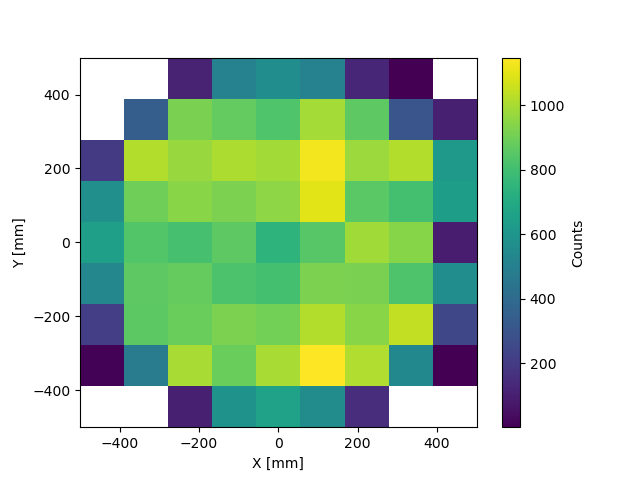

In [6]:
%matplotlib widget
fig, ax = plt.subplots()
has_nan = data_properties['x'].isna().any()
print(has_nan)

hist, xedges, yedges = np.histogram2d(data_properties.x, data_properties.y, bins=[np.linspace(-500,500,10),np.linspace(-500,500,10)])

# 2. Mask zero bins
masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

# 3. Create a custom colormap with white for the masked values (zero bins)
cmap = plt.cm.viridis  # Choose a colormap you like
cmap.set_bad(color='white')  # Set masked values (zeros) to white

# 4. Plot the 2D histogram

pcm = ax.pcolormesh(xedges, yedges, masked_hist.T, cmap=cmap)

# Add color bar
plt.colorbar(pcm, ax=ax, label='Counts')

plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")



In [7]:
data_properties_active = data_properties[ (data_properties.deltaT > 0) & (data_properties.deltaT < 795)]

5.175577423717887 46.33042151593324


/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_84416/3476455047.py:61: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_bad(color='white')  # Set masked values (zeros) to white


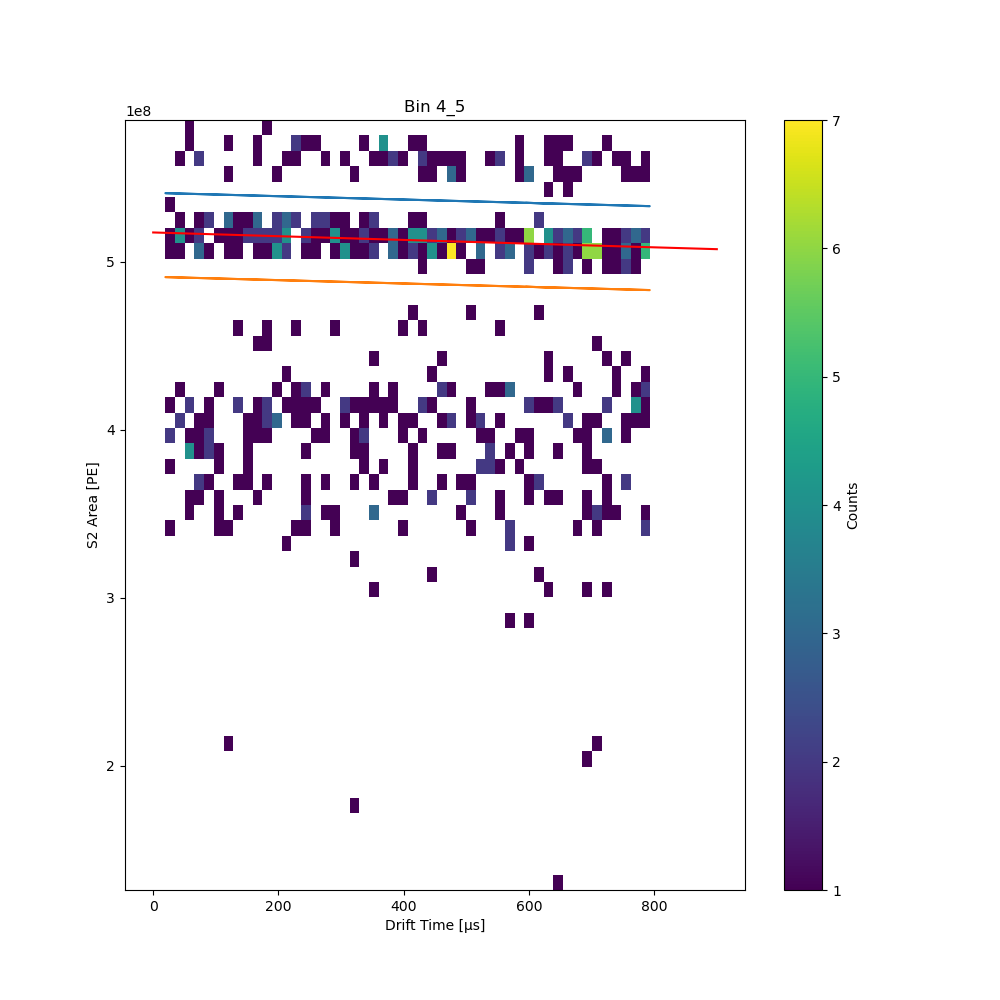

In [40]:
# Define the exponential decay function
def exp_decay(t, q, tau):
    return q * np.exp(-t / tau)

def FitLifetime(df, binid):

    # Filter data based on the current bin_id
    df_bin = df[df.bin_id == binid] 

    # Get the histogram with the most counts to find the main alpha peak
    counts, bin_edges = np.histogram(df_bin.S2_area, bins=50) 
    max_bin_index = np.argmax(counts)  # Index of the bin with the most counts
    max_bin_value = bin_edges[max_bin_index]  # Left edge of the bin with the most counts

    if (mode == "raw"):
        lower_bound = max_bin_value-0.25e8 + 0.3e8
        upper_bound = max_bin_value+0.25e8 + 0.3e8

        df_bin = df_bin[ (df_bin.S2_area > -5e4*df_bin.deltaT+lower_bound) & (df_bin.S2_area < -5e4*df_bin.deltaT+upper_bound)  ]
    
    else:
        lower_bound = max_bin_value-0.25e8 + 0.05e8
        upper_bound = max_bin_value+0.25e8 + 0.05e8

        df_bin = df_bin[ (df_bin.S2_area > -1e4*df_bin.deltaT+lower_bound) & (df_bin.S2_area < -1e4*df_bin.deltaT+upper_bound)  ]

    if (len(df_bin) < 20):
        return 0, 0

    # Make 2D hist for binning
    hist, x_edges, y_edges = np.histogram2d(df_bin['deltaT'], df_bin['S2_area'], bins=100)

    t = np.linspace(0,800,300)
    plt.plot(df_bin['deltaT'], -1e4*df_bin.deltaT+upper_bound)
    plt.plot(df_bin['deltaT'], -1e4*df_bin.deltaT+lower_bound)
    
    # Perform the curve fit
    params, covariance = curve_fit(exp_decay, df_bin.deltaT, df_bin.S2_area, bounds = ([1e8, 1e3], [8.5e8, 100e3]))


    # Extract the fitted parameters
    q_fit, tau_fit = params
    print(q_fit/1e8, tau_fit/1e3 )

    return q_fit, tau_fit


fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Filter data based on the current bin_id
df_bin = data_properties_active[data_properties_active.bin_id == "5_5"] # 4_5, 

# Create 2D histogram
hist, x_edges, y_edges = np.histogram2d(df_bin['deltaT'], df_bin['S2_area'], bins=50)

# Mask zero bins
masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

# Custom colormap
cmap = plt.cm.viridis
cmap.set_bad(color='white')  # Set masked values (zeros) to white

# Plot with pcolormesh
pcm = ax.pcolormesh(x_edges, y_edges, masked_hist.T, cmap=cmap)

# Add color bar
plt.colorbar(pcm, ax=ax, label='Counts')

# Set labels
ax.set_xlabel("Drift Time [μs]")
ax.set_ylabel("S2 Area [PE]")
ax.set_title(f"Bin 4_5")
# ax.set_ylim(2.5e8,4.5e8)

# # Generate fitted curve
t_fit = np.linspace(0, 900, 100)

q_fit, tau_fit = FitLifetime(data_properties_active, "5_5")
hist_fit = exp_decay(t_fit, q_fit, tau_fit)

# # Plotting the fitted exponential decay curve
ax.plot(t_fit, hist_fit, 'r-', label=f'Fit: q={q_fit:.2f}, tau={tau_fit:.2f}')



/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_84237/253154812.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return q * np.exp(-t / tau)
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_84237/253154812.py:3: RuntimeWarning: invalid value encountered in true_divide
  return q * np.exp(-t / tau)
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_84237/253154812.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return q * np.exp(-t / tau)
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_84237/253154812.py:3: RuntimeWarning: invalid value encountered in true_divide
  return q * np.exp(-t / tau)
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_84237/253154812.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return q * np.exp(-t / tau)
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_84237/253154812.py:3: RuntimeWarning: invalid value encountered in true_divide
  return q * np.exp

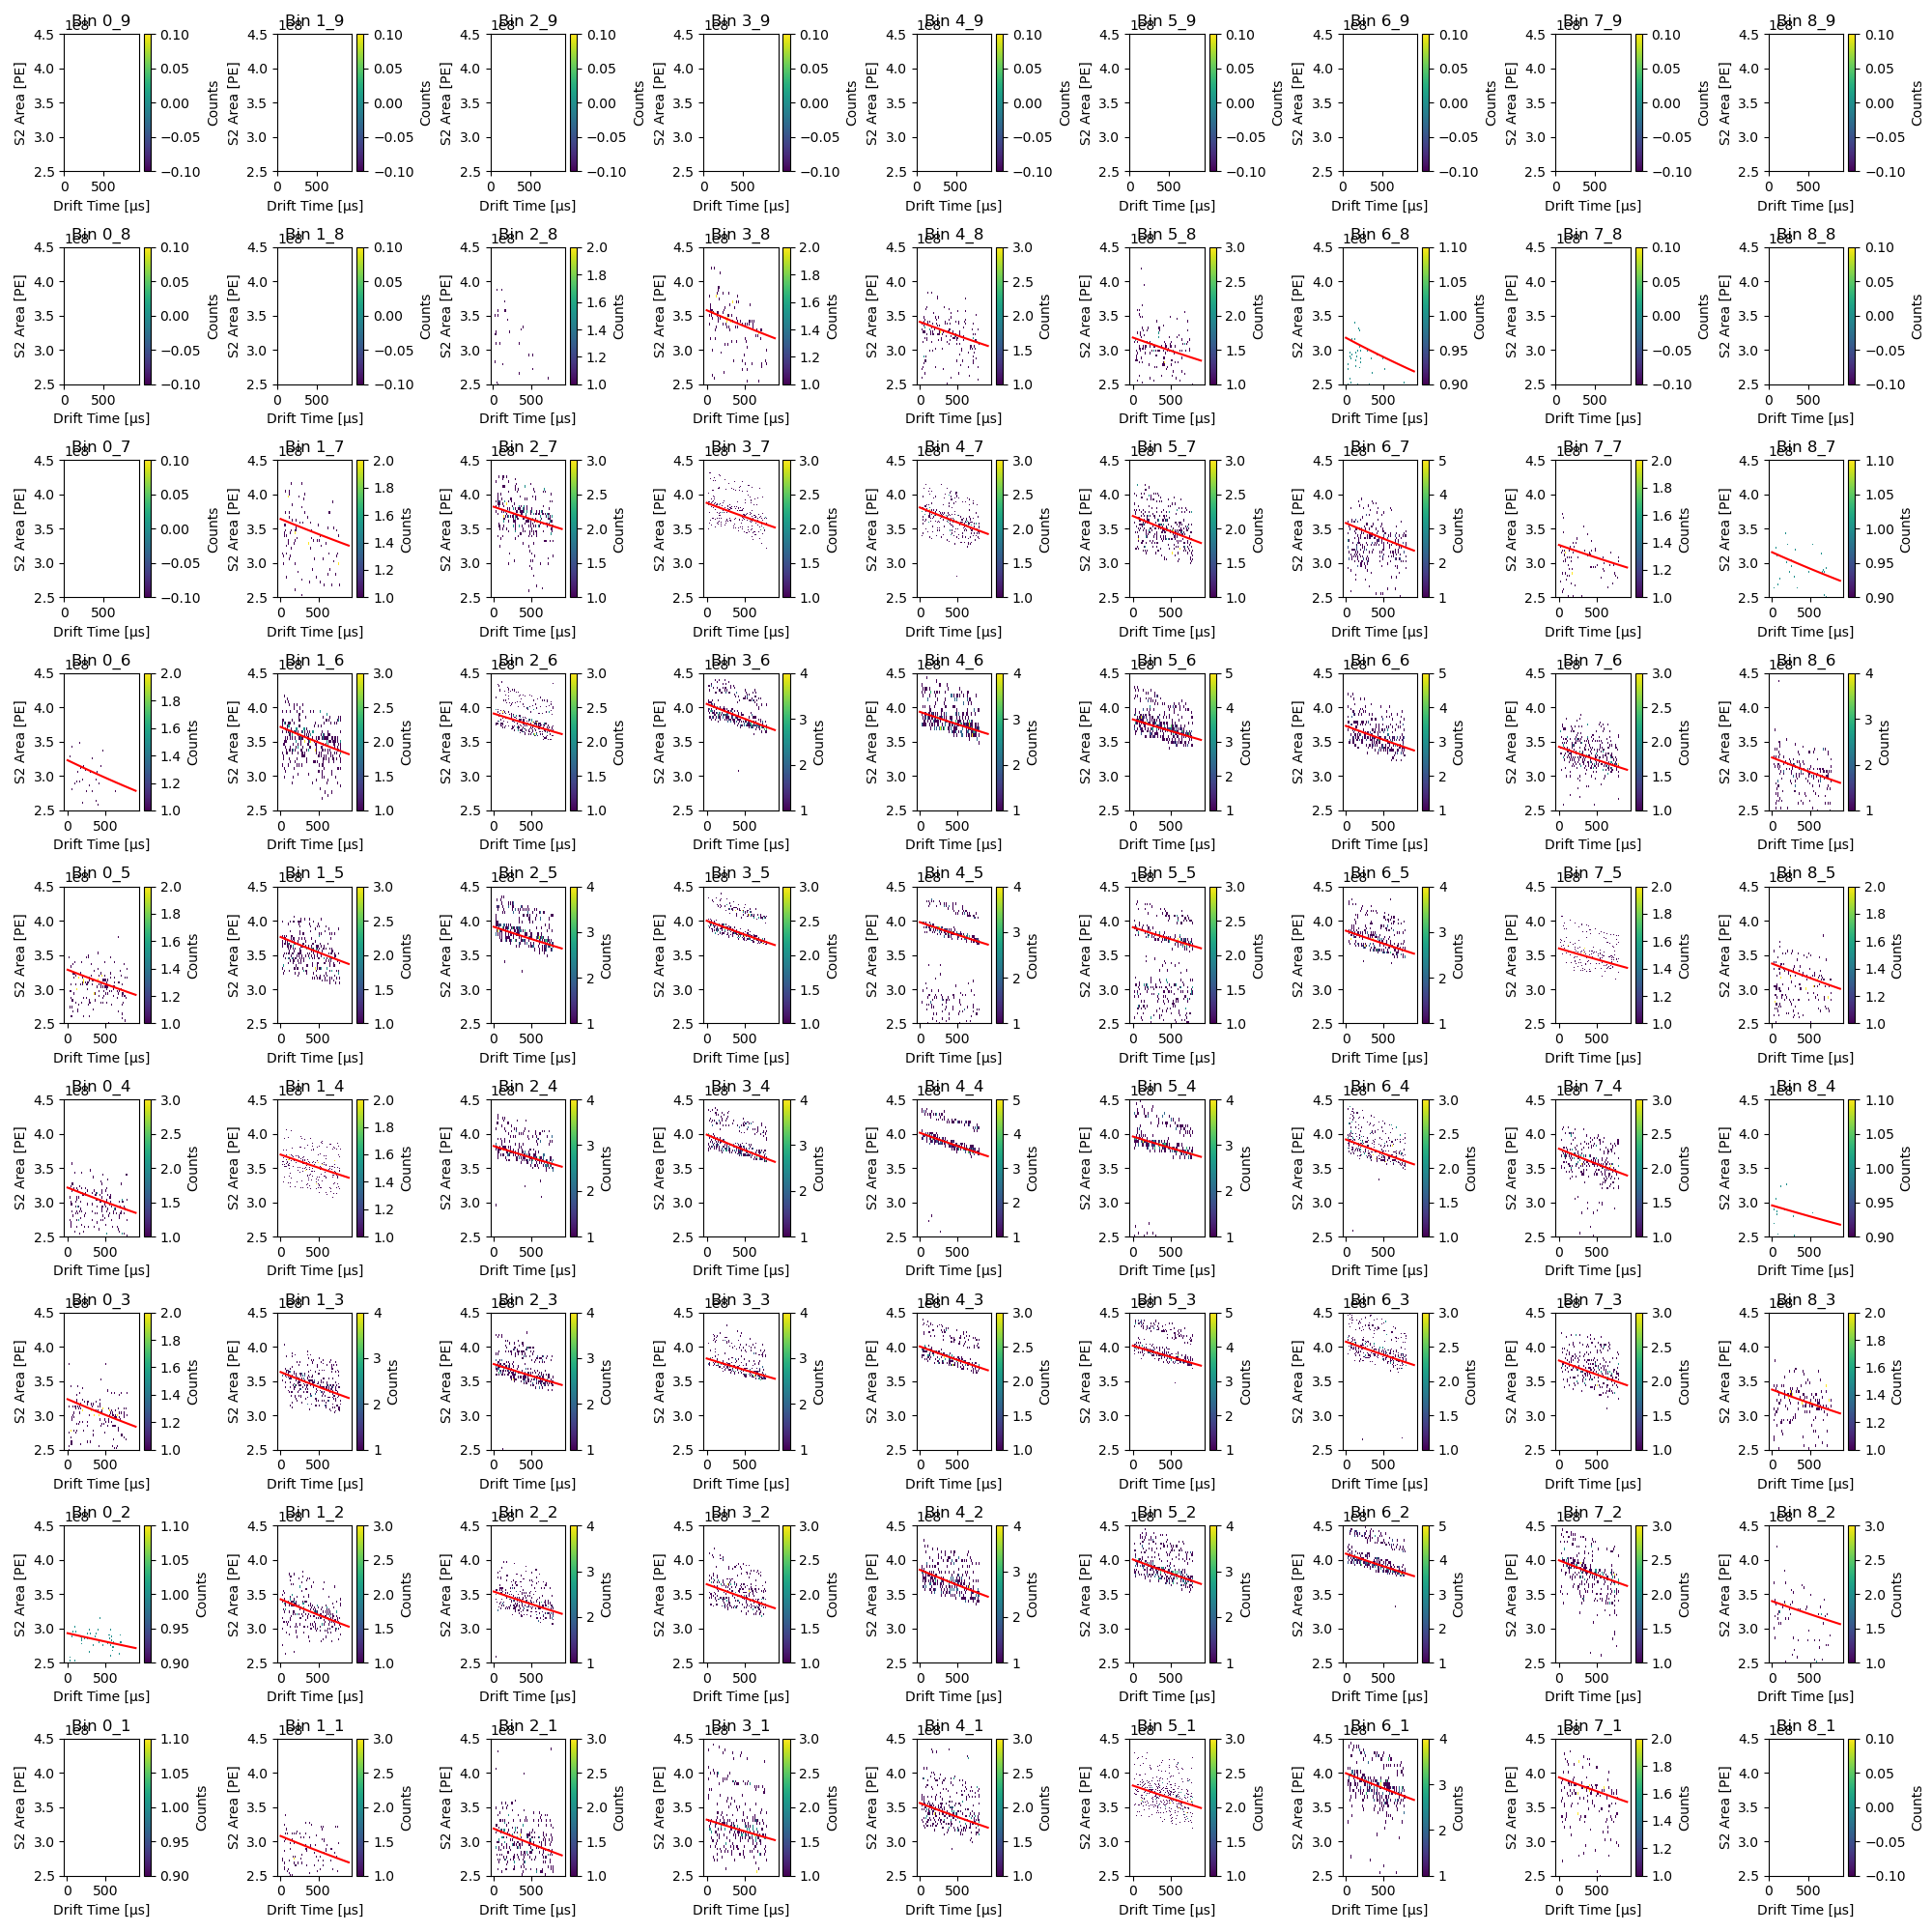

In [42]:
# Make a plot of the time vs peak width

data_properties_active['sigma'] = data_properties_active['sigma'].fillna(0)
data_properties_active['S2_amp'] = data_properties_active['S2_amp'].fillna(-1)
data_properties_active = data_properties_active[data_properties_active.S2_amp > 0]

data_properties['sigma'] = data_properties['sigma'].fillna(0)
data_properties['S2_amp'] = data_properties['S2_amp'].fillna(-1)
data_properties = data_properties[data_properties.S2_amp > 0]


# Define the plot function
def plot_lifetime(ax, df, S2var, bin_id):
    # Filter data based on the current bin_id
    df_bin = df[df.bin_id == bin_id]

    # Create 2D histogram
    hist, xedges, yedges = np.histogram2d(df_bin['deltaT'], df_bin[S2var], bins=100)

    # Mask zero bins
    masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

    # Custom colormap
    # cmap = plt.cm.viridis
    cmap = plt.cm.get_cmap("viridis").copy()
    cmap.set_bad(color='white')  # Set masked values (zeros) to white

    # Plot with pcolormesh
    pcm = ax.pcolormesh(xedges, yedges, masked_hist.T, cmap=cmap)

    # Add color bar
    plt.colorbar(pcm, ax=ax, label='Counts')

    # Set labels
    ax.set_xlabel("Drift Time [μs]")
    ax.set_ylabel("S2 Area [PE]")
    ax.set_title(f"Bin {bin_id}")
    ax.set_ylim(2.5e8,4.5e8)


# Create a grid of subplots (5x5)
fig, axs = plt.subplots(9, 9, figsize=(20, 20))  # Adjusted figsize for better spacing
axs = axs.flatten()  # Flatten the 2D array of subplots into a 1D array for easier indexing

lifetime_df = pd.DataFrame(columns=["bin_id", "lt", "q0"])

# Iterate over the unique bin_id values and corresponding subplot axes
counter = 0
for y in range(9, -1, -1):
    for x in range(0, 9, 1):
        if counter >= len(axs):
            break  # Avoid indexing beyond available subplots
        plot_lifetime(axs[counter], data_properties_active, "S2_area",f"{x}_{y}")

        t_fit = np.linspace(0, 900, 100)

        q_fit, tau_fit = FitLifetime(data_properties_active, f"{x}_{y}")
        hist_fit = exp_decay(t_fit, q_fit, tau_fit)

        # # Plotting the fitted exponential decay curve
        axs[counter].plot(t_fit, hist_fit, 'r-', label=f'Fit: q={q_fit:.2f}, tau={tau_fit:.2f}')

        # Create a new DataFrame to append
        new_data = pd.DataFrame({
            "bin_id": [f"{x}_{y}"],
            "lt": [tau_fit],
            "q0": [q_fit]
        })

        lifetime_df = pd.concat([lifetime_df, new_data], ignore_index=True)

        counter=counter+1

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


In [30]:
# Plot the alpha map of

def CorrectLifetime(row, var, q0_max):

    lt = row["lt"]
    time = row["deltaT"]
    q0 = row["q0"]

    if (q0 == 0):
        q_corr = 1
    else:
        q_corr = q0_max/q0


    if (lt == 0):
        return 1
    else:
        return q_corr * row[var] / np.exp(-1*time/lt)

def CorrectLifetimeAvg(row, var, t, mean_lt):

    time = row[t]

    if (mean_lt == 0):
        return 1
    else:
        return row[var] / np.exp(-1*time/mean_lt)



mean_lt = np.mean(lifetime_df[lifetime_df["lt"] > 0]["lt"])
print("Mean Lifetime is:", mean_lt/1e3, " ms")

data_properties_active_lt = pd.merge(data_properties_active, lifetime_df, on="bin_id", how="left")
q0_max = np.max(data_properties_active_lt.q0)
data_properties_active_lt["S2_areaC"] = data_properties_active_lt.apply(lambda row: CorrectLifetime(row, "S2_area", q0_max), axis=1)
data_properties_active_lt["R"] = np.sqrt(data_properties_active_lt["x"]*data_properties_active_lt["x"] + data_properties_active_lt["y"]*data_properties_active_lt["y"])

data_properties_lt = pd.merge(data_properties, lifetime_df, on="bin_id", how="left")
q0_max = np.max(data_properties_lt.q0)
data_properties_lt["S2_areaC"] = data_properties_lt.apply(lambda row: CorrectLifetime(row,"S2_area", q0_max), axis=1)
data_properties_lt["R"] = np.sqrt(data_properties_lt["x"]*data_properties_lt["x"] + data_properties_lt["y"]*data_properties_lt["y"])
data_properties_lt["cath_areaC"] = data_properties_lt.apply(lambda row: CorrectLifetimeAvg(row,"cath_area", "deltaT",  mean_lt), axis=1)


nan_event_ids = data_properties_lt[data_properties_lt['R'].isna()]['event'].values
print(nan_event_ids)

display(data_properties_active_lt)


Mean Lifetime is: 9.02619042057072  ms
[]


,event,S2_area,cath_area,ts_raw,deltaT,sigma,S2_amp,x,y,grass_peaks,...,ts,x_bin,y_bin,x_bin_center,y_bin_center,bin_id,lt,q0,S2_areaC,R
0,27760,3.620563e+08,8.506972e+05,1.723015e+09,91.375,3.288948,1.151331e+06,149.925,-371.075,0.0,...,2024-08-07 02:12:55.076,5,1,111.111111,-333.333333,5_1,10039.123751,381525836.913754,3.916225e+08,400.217642
1,27767,3.720135e+08,2.093862e+06,1.723015e+09,682.400,5.186409,7.778402e+05,-204.725,106.975,0.0,...,2024-08-07 02:12:55.614,2,5,-222.222222,111.111111,2_5,10676.181146,391040190.237304,4.147240e+08,230.989126
2,27781,3.621512e+08,1.005992e+06,1.723015e+09,738.350,5.188740,7.415586e+05,-126.975,-31.975,0.0,...,2024-08-07 02:12:56.134,3,4,-111.111111,0.000000,3_4,8597.328551,398577185.431995,4.048908e+08,130.939113
3,27788,3.657642e+08,1.595617e+06,1.723015e+09,782.750,5.694477,6.884924e+05,26.525,-325.425,1.0,...,2024-08-07 02:12:56.454,4,1,0.000000,-333.333333,4_1,8460.10246,356051945.571765,4.608212e+08,326.504221
4,27795,2.479531e+08,6.200161e+05,1.723015e+09,145.900,3.235227,8.012001e+05,412.275,-48.025,0.0,...,2024-08-07 02:12:56.864,8,4,444.444444,0.000000,8_4,9007.36211,295425379.267023,3.488341e+08,415.062738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28655,16961,3.951035e+08,1.189783e+06,1.723014e+09,487.125,4.676535,9.024124e+05,10.975,276.025,0.0,...,2024-08-07 02:03:19.939,4,6,0.000000,222.222222,4_6,10544.034295,393812254.793294,4.296831e+08,276.243102
28656,16968,4.387904e+08,1.196245e+06,1.723014e+09,53.525,2.596031,1.644214e+06,196.575,29.225,0.0,...,2024-08-07 02:03:20.355,6,4,222.222222,0.000000,6_4,9253.067363,391597988.406728,4.608838e+08,198.735581
28657,16982,3.551584e+08,8.077018e+05,1.723014e+09,20.125,1.968122,1.719874e+06,26.525,-340.975,1.0,...,2024-08-07 02:03:21.263,4,1,0.000000,-333.333333,4_1,8460.10246,356051945.571765,4.088881e+08,342.005155
28658,16989,3.609424e+08,9.058487e+05,1.723014e+09,383.925,4.195236,9.142734e+05,-50.225,-202.025,0.0,...,2024-08-07 02:03:21.857,4,2,0.000000,-222.222222,4_2,8373.188634,385510896.566773,4.008455e+08,208.174569


,event,S2_area,cath_area,ts_raw,deltaT,sigma,S2_amp,x,y,grass_peaks,...,ts,x_bin,y_bin,x_bin_center,y_bin_center,bin_id,lt,q0,S2_areaC,R
29,28089,2.165812e+08,694736.09976,1.723015e+09,710.025,5.124080,4.550416e+05,88.725,60.325,1.0,...,2024-08-07 02:13:12.123,5,5,111.111111,111.111111,5_5,11014.156169,390365796.560338,2.419961e+08,107.290406
101,41433,1.827639e+08,618799.15488,1.723016e+09,39.150,2.355919,7.723342e+05,57.625,29.225,0.0,...,2024-08-07 02:25:04.418,5,4,111.111111,0.000000,5_4,11572.077706,395932224.614347,1.894093e+08,64.612238
108,41496,2.876435e+08,809203.83240,1.723016e+09,24.325,2.817941,1.016604e+06,73.175,75.875,0.0,...,2024-08-07 02:25:07.710,5,5,111.111111,111.111111,5_5,11014.156169,390365796.560338,3.019983e+08,105.411557
147,1770,2.908713e+08,717071.67760,1.723013e+09,322.325,3.906366,7.717152e+05,57.625,91.425,0.0,...,2024-08-07 01:49:46.945,5,5,111.111111,111.111111,5_5,11014.156169,390365796.560338,3.137625e+08,108.070214
178,2106,2.420495e+08,642340.23416,1.723013e+09,708.325,5.031154,5.212075e+05,42.075,75.875,0.0,...,2024-08-07 01:50:05.749,4,5,0.000000,111.111111,4_5,10488.708151,397778901.112198,2.662281e+08,86.760136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28399,29681,1.835898e+08,593120.72192,1.723015e+09,125.425,2.956920,6.509601e+05,57.625,29.225,0.0,...,2024-08-07 02:14:35.661,5,4,111.111111,0.000000,5_4,11572.077706,395932224.614347,1.916891e+08,64.612238
28459,37323,2.743329e+08,624088.60056,1.723015e+09,76.575,2.932752,9.425815e+05,104.275,60.325,0.0,...,2024-08-07 02:21:26.338,5,5,111.111111,111.111111,5_5,11014.156169,390365796.560338,2.893931e+08,120.467345
28462,37358,2.859081e+08,801776.52280,1.723015e+09,171.575,3.088482,9.247990e+05,42.075,91.425,0.0,...,2024-08-07 02:21:28.048,4,5,0.000000,111.111111,4_5,10488.708151,397778901.112198,2.987800e+08,100.642120
28474,29013,2.511532e+08,631043.22320,1.723015e+09,213.200,3.453339,7.529398e+05,57.625,60.325,0.0,...,2024-08-07 02:14:00.370,5,5,111.111111,111.111111,5_5,11014.156169,390365796.560338,2.682477e+08,83.425094


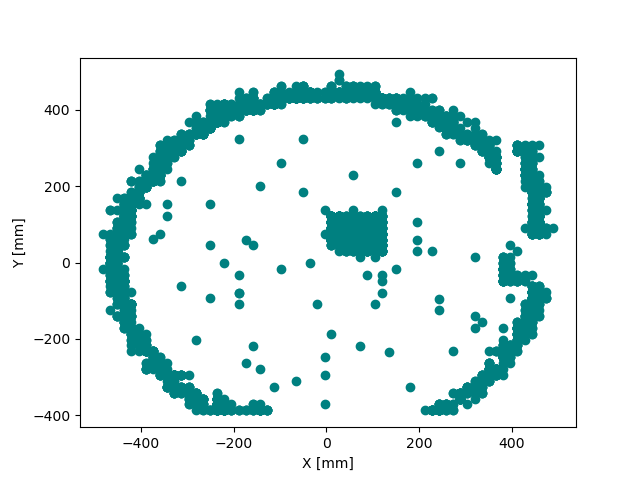

In [43]:
plt.figure()

low_E_S2 = data_properties_active_lt[data_properties_active_lt.S2_areaC < 3.5e8]
plt.scatter(low_E_S2.x, low_E_S2.y, color = "Teal")
plt.xlabel("X [mm]")
plt.ylabel("Y [mm]")

display(low_E_S2[low_E_S2.R < 200])


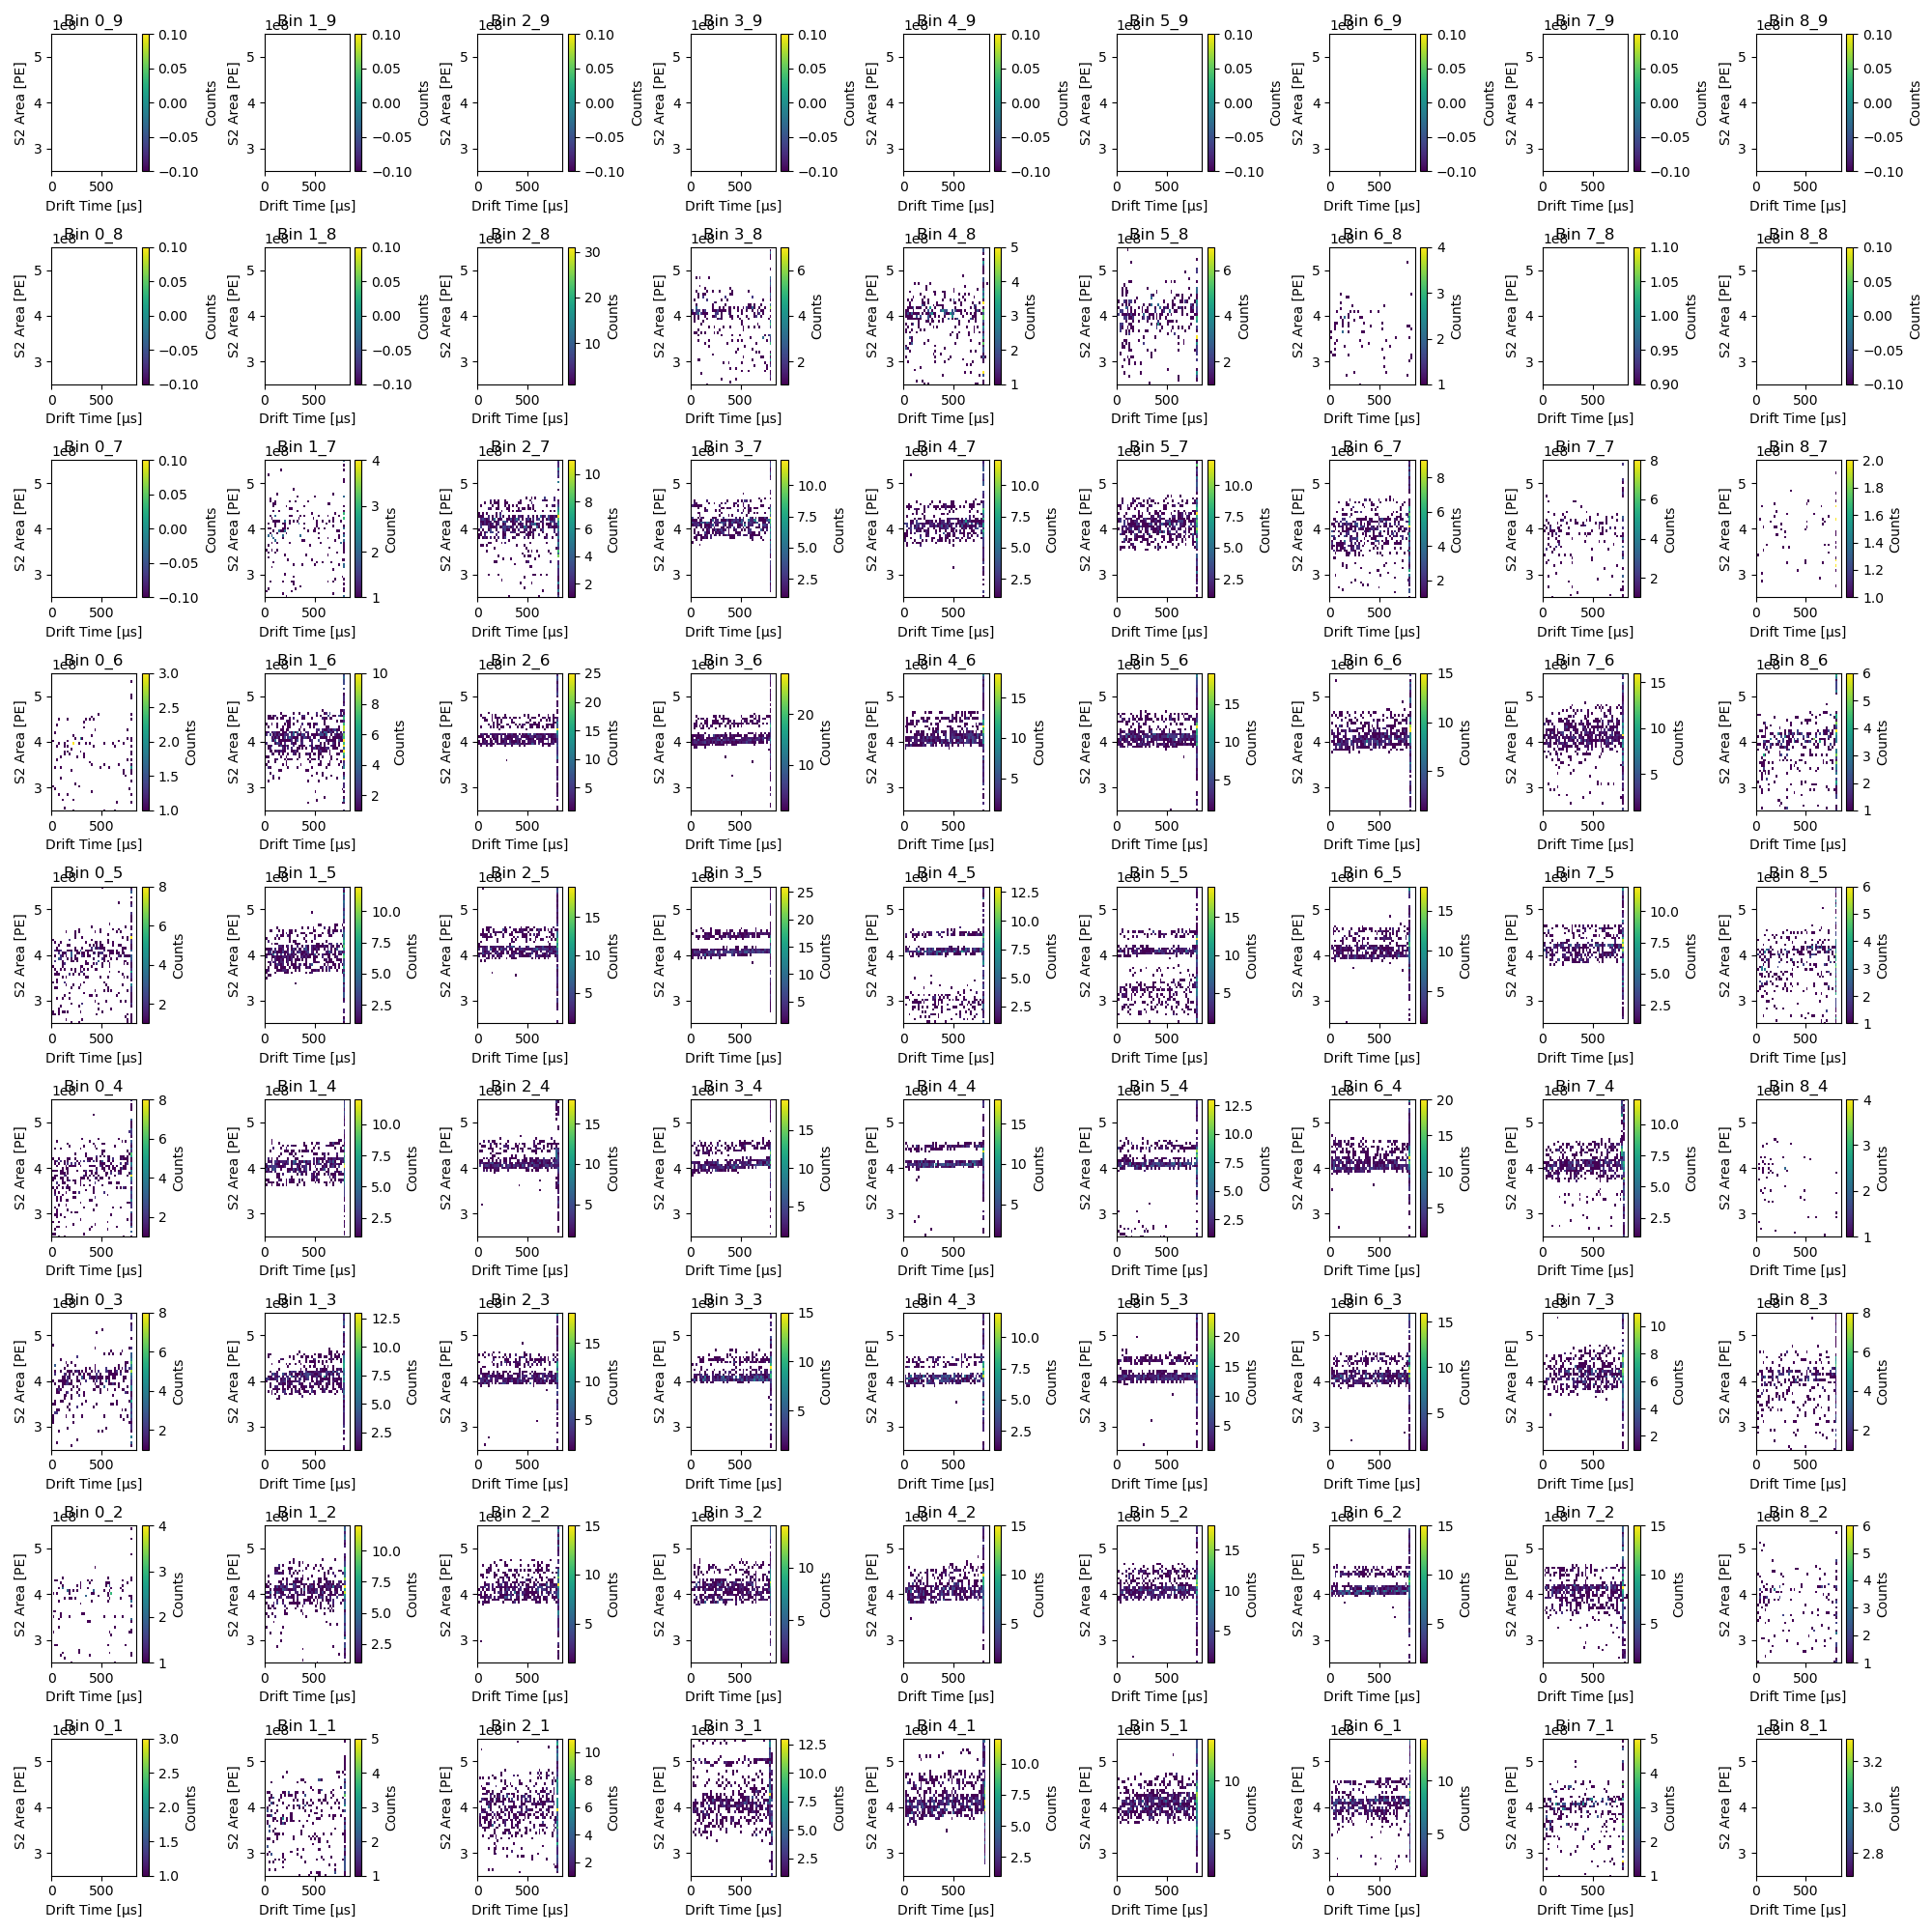

In [44]:
# Create a grid of subplots (5x5)
fig, axs = plt.subplots(9, 9, figsize=(20, 20))  # Adjusted figsize for better spacing
axs = axs.flatten()  # Flatten the 2D array of subplots into a 1D array for easier indexing

# lifetime_df = pd.DataFrame(columns=["bin_id", "lt", "q0"])

# Iterate over the unique bin_id values and corresponding subplot axes
counter = 0
for y in range(9, -1, -1):
    for x in range(0, 9, 1):
        if counter >= len(axs):
            break  # Avoid indexing beyond available subplots
        plot_lifetime(axs[counter], data_properties_lt, "S2_areaC",f"{x}_{y}")   
        axs[counter].set_xlim(0,850)
        axs[counter].set_ylim(2.5e8,5.5e8)

        counter=counter+1

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Fit the distribution 
def Gaussian_(x, A, mu, sigma):
    return A * np.exp(-(x-mu)*(x-mu)/(2*sigma*sigma))

# Line
def Line(x, m, c):
    return m*x+c

4.07616735893529
PE conv factor =  1.3738395671424886e-08


Text(567751882.1374154, 175, '7.7 MeV')

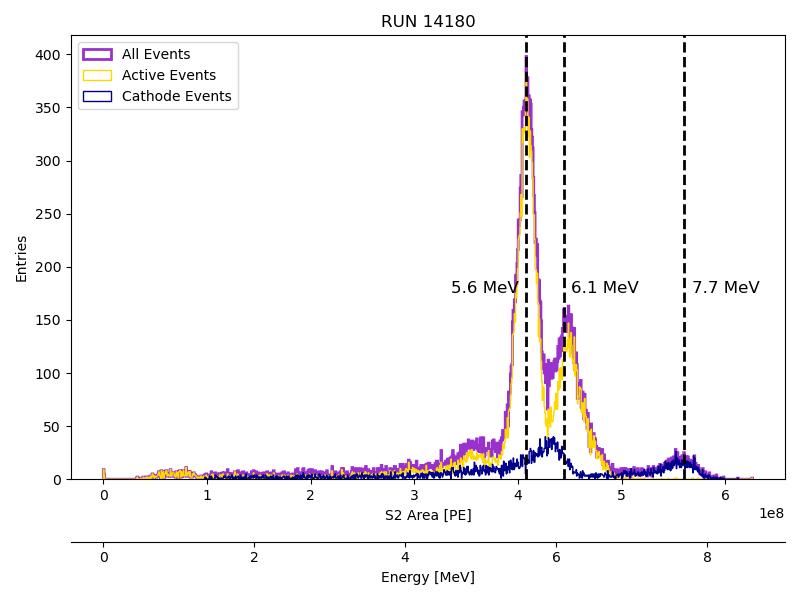

In [ ]:
Radial_Cut = 350

# Histogram the S2 energy
fig, ax1 = plt.subplots(figsize = (8,6))

ax1.hist(data_properties_lt[data_properties_lt.R < Radial_Cut].S2_areaC, bins = 1000, histtype = "step", color = "darkorchid", linewidth=2, label = "All Events");
ax1.set_xlabel("S2 Area [PE]")
ax1.set_ylabel("Entries")

# plt.hist(data_properties_active[data_properties_active.cath_area < 50e3].S2_area, bins = 200, histtype = "step");
counts, xbins, _ = ax1.hist(data_properties_lt[(data_properties_lt.deltaT<794) & (data_properties_lt.R< Radial_Cut)].S2_areaC, bins = 1000, histtype = "step", label="Active Events", color="gold");
ax1.hist(data_properties_lt[(data_properties_lt.deltaT>794) & (data_properties_lt.R< Radial_Cut)].S2_areaC, bins = 1000, histtype = "step", label="Cathode Events", color="DarkBlue");
ax1.legend(loc="upper left")


bin_centers = (xbins[:-1] + xbins[1:]) / 2

max_bin_index = np.argmax(counts)  # Index of the bin with the most counts
max_bin_value = xbins[max_bin_index]

print(max_bin_value/1e8)
PE_to_MeV = 5.6/max_bin_value
print("PE conv factor = ", PE_to_MeV)

ax1.set_title(f"RUN {RUN}")

# Create secondary x-axis
# ax2 = ax1.twiny()
# ax2.set_xlabel("Energy [MeV] (Secondary Axis)")

# Set limits and fewer tick positions for the secondary x-axis
ax2.set_xlim(ax1.get_xlim())


ax2 = ax1.secondary_xaxis("bottom", functions=(lambda x: x * PE_to_MeV, lambda x: x / PE_to_MeV))
ax2.set_xlabel("Energy [MeV]")
ax2.spines['bottom'].set_position(('outward', 45))

fig.tight_layout()

# plt.hist(data_properties_lt[data_properties_lt.R < Radial_Cut].S2_areaC*PE_to_MeV, bins = 1000, histtype = "step", color = "darkorchid", linewidth=2, label = "All Events");
# plt.xlabel("S2 Area [MeV]")
# plt.ylabel("Entries")

# # plt.hist(data_properties_active[data_properties_active.cath_area < 50e3].S2_area, bins = 200, histtype = "step");
# counts, xbins, _ = plt.hist(data_properties_lt[(data_properties_lt.deltaT<794)& (data_properties_lt.R< Radial_Cut)].S2_areaC*PE_to_MeV, bins = 1000, histtype = "step", label="Active Events", color="gold");
# plt.hist(data_properties_lt[(data_properties_lt.deltaT>794) & (data_properties_lt.R< Radial_Cut)].S2_areaC*PE_to_MeV, bins = 1000, histtype = "step", label="Cathode Events", color="DarkBlue");
# plt.legend(loc="upper left")

ax1.axvline(5.6/PE_to_MeV, linestyle = "--", color = "k", linewidth = 2)
ax1.axvline(6.1/PE_to_MeV, linestyle = "--", color = "k", linewidth = 2)
ax1.axvline(7.7/PE_to_MeV, linestyle = "--", color = "k", linewidth = 2)
plt.title(f"RUN {RUN}")

ax1.text(4.6/PE_to_MeV, 175, '5.6 MeV', fontsize=12)
ax1.text(6.2/PE_to_MeV, 175, '6.1 MeV', fontsize=12)
ax1.text(7.8/PE_to_MeV, 175, '7.7 MeV', fontsize=12)

1.292372477478622 9.709628636813688


/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_24687/2341539982.py:16: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_bad(color='white')  # Set masked values (zeros) to white


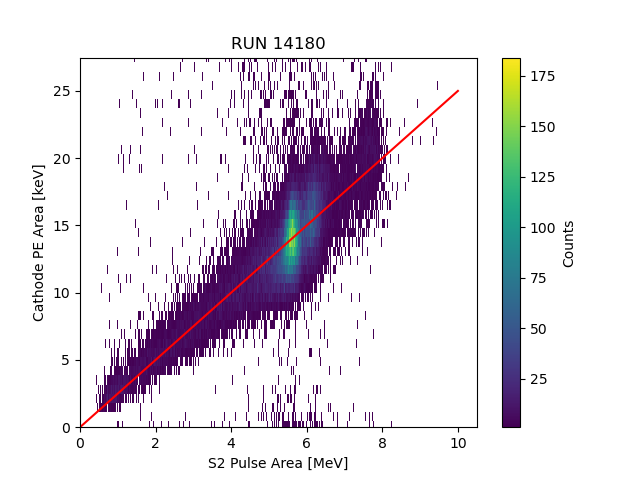

In [ ]:
# 1. Create the 2D histogram

data_properties_lt['S2_areaC'] = data_properties_lt['S2_areaC'].fillna(0)
data_properties_lt['cath_areaC'] = data_properties_lt['cath_areaC'].fillna(0)

data_properties_lt_radial = data_properties_lt[data_properties_lt.R < 500]

# hist, xedges, yedges = np.histogram2d(data_properties_active.S2_area, data_properties_active.cath_area, bins=100)
hist, xedges, yedges = np.histogram2d(data_properties_lt_radial.S2_areaC*PE_to_MeV, data_properties_lt_radial.cath_areaC*PE_to_MeV*1000, bins=[500, 1000])

# 2. Mask zero bins
masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

# 3. Create a custom colormap with white for the masked values (zero bins)
cmap = plt.cm.viridis  # Choose a colormap you like
cmap.set_bad(color='white')  # Set masked values (zeros) to white

# 4. Plot the 2D histogram
fig, ax = plt.subplots()
pcm = ax.pcolormesh(xedges, yedges, masked_hist.T, cmap=cmap)

# Add color bar
plt.colorbar(pcm, ax=ax, label='Counts')

plt.xlabel("S2 Pulse Area [MeV]")
plt.ylabel("Cathode PE Area [keV]")
# plt.ylim(0,2e6)
plt.ylim(0,2e6*PE_to_MeV*1000)

plt.title(f"RUN {RUN}")

S2_arr = np.linspace(0,10, 100)

# Perform the curve fit
# params, covariance = curve_fit(Line, data_properties_lt_radial.S2_areaC*PE_to_MeV, data_properties_lt_radial.cath_areaC*PE_to_MeV*1000, bounds = ([1e8, 1e3], [4.5e8, 100e3]))
params, covariance = curve_fit(Line, data_properties_lt_radial.S2_areaC*PE_to_MeV, data_properties_lt_radial.cath_areaC*PE_to_MeV*1000)

# Extract the fitted parameters
m, c = params

print(m,c)

plt.plot(S2_arr, Line(S2_arr, 2.5, 0), c = "red")


In [ ]:
# Define the plot function
def plot_S2(ax, df, bin_id):
    # Filter data based on the current bin_id
    df_bin = df[df.bin_id == bin_id]

    ax.hist(df_bin[(df_bin.deltaT<794)].S2_area, bins = 10, histtype = "step", label="Active Events", color="gold");
    ax.hist(df_bin[(df_bin.deltaT>794)].S2_area, bins = 10, histtype = "step", label="Cathode Events", color="DarkBlue");

    # Set labels
    ax.set_xlabel("S2 Area [PE]")
    ax.set_ylabel("Counts")
    ax.set_title(f"Bin {bin_id}")


# # Create a grid of subplots (5x5)
# fig, axs = plt.subplots(10, 10, figsize=(20, 20))  # Adjusted figsize for better spacing
# axs = axs.flatten()  # Flatten the 2D array of subplots into a 1D array for easier indexing

# # Iterate over the unique bin_id values and corresponding subplot axes
# counter = 0
# for y in range(9, -1, -1):
#     for x in range(0, 9, 1):
#         if counter >= len(axs):
#             break  # Avoid indexing beyond available subplots
#         plot_S2(axs[counter], data_properties, f"{x}_{y}")
#         counter=counter+1

# # Adjust layout to avoid overlap
# plt.tight_layout()

# # Show the plot
# plt.show()

,event,ts_raw,pmt,pe_int,peak_time,noise_thr,ts
0,27760,1.723015e+09,0,927.88992,1393.375,109.827369,2024-08-07 02:12:55.076
1,27760,1.723015e+09,0,829.00992,1396.225,109.827369,2024-08-07 02:12:55.076
2,27760,1.723015e+09,0,1916.68992,1400.800,109.827369,2024-08-07 02:12:55.076
3,27760,1.723015e+09,0,1685.96992,1424.500,109.827369,2024-08-07 02:12:55.076
4,27760,1.723015e+09,0,2147.40992,1498.625,109.827369,2024-08-07 02:12:55.076
...,...,...,...,...,...,...,...
46858,17010,1.723014e+09,59,1754.34552,1496.200,124.997392,2024-08-07 02:03:22.813
46859,17010,1.723014e+09,59,1345.02552,1530.075,124.997392,2024-08-07 02:03:22.813
46860,17010,1.723014e+09,59,662.82552,1558.600,124.997392,2024-08-07 02:03:22.813
46861,17010,1.723014e+09,59,1310.91552,1578.100,124.997392,2024-08-07 02:03:22.813


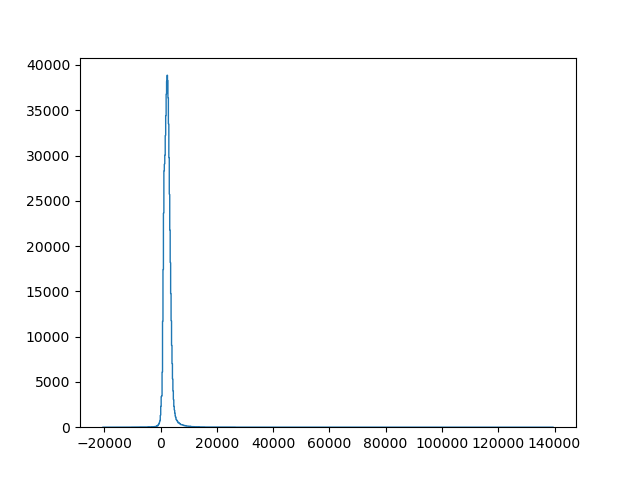

In [ ]:
plt.figure()

plt.hist(data[data.pmt == 4].pe_int, bins = 1000, histtype = "step");
data# plt.semilogy()

In [ ]:
data_copy  = data.copy()
data_copy['peak_time'] = data['peak_time'] - 1000
data_copy["pe_intC"] = data_copy.apply(lambda row: CorrectLifetimeAvg(row,"pe_int", "peak_time",  mean_lt), axis=1)


In [ ]:
data_grouped = data_copy.groupby(['event', 'peak_time'])['pe_intC'].sum().reset_index()
data_grouped["pe_intC"] = data_grouped["pe_intC"]*PE_to_MeV*1e6
# display(data_grouped)
display(data_grouped)

,event,peak_time,pe_intC
0,1,350.225,27.757152
1,1,351.375,58.432133
2,1,351.650,43.496865
3,1,351.800,33.156214
4,1,351.850,18.321825
...,...,...,...
29618569,52145,758.925,-3.874254
29618570,52145,759.075,-0.306857
29618571,52145,759.200,-0.927719
29618572,52145,759.325,-0.193482


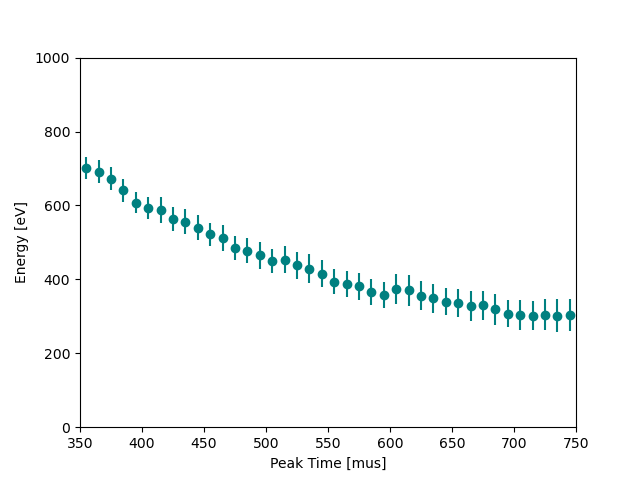

17898.1475276046
1558.922898017486 422.7009817503226


Text(0.5, 1.0, 'RUN 14180')

In [ ]:
# Get the distrubution of the summation of all the bits
plt.figure()

radial_events = data_properties_lt[data_properties_lt.R < 350].event.unique()

binwidths = 10
bins = np.arange(350, 770,binwidths )
bin_centers = (bins[:-1] + bins[1:]) / 2

# plt.hist(data_grouped.peak_time,weights=1*data_grouped.pe_intC/len(data_grouped.event.unique()), histtype="step", bins =bins);

data_grouped_radial = data_grouped[data_grouped.event.isin(radial_events)]


counts_mean, edges_mean =np.histogram(data_grouped_radial.peak_time, weights=data_grouped_radial.pe_intC, bins = bins )

# Norm counts by the number of events and the bin size
# counts = counts/(len(data_grouped.event.unique())*binwidths)
counts_mean = counts_mean/(len(data_grouped_radial.event.unique()))

# Calculate standard deviation for each bin
std_devs = []
for i in range(len(edges) - 1):
    in_bin = (data_grouped_radial.peak_time >= edges[i]) & (data_grouped_radial.peak_time < edges[i+1])
    std_devs.append(data_grouped_radial.loc[in_bin, 'pe_intC'].std())

# Plot
# plt.scatter(bin_centers, counts, label="Mean Counts")
# plt.errorbar(bin_centers, counts, yerr=np.array(std_devs)/binwidths, fmt='o', color='Teal')
plt.errorbar(bin_centers, counts_mean, yerr=np.array(std_devs), fmt='o', color='Teal')

# plt.ylim(0, 200)
plt.ylim(0,1000)
plt.xlim(350,750)


plt.xlabel('Peak Time [mus]')
plt.ylabel('Energy [eV]')
plt.show()


times = np.linspace(0,800, 100)


# Perform the curve fit
params, covariance = curve_fit(exp_decay, bin_centers, counts_mean, p0=[1500, 500 ], bounds = ([0, 10], [2000, 5e3]))

# Extract the fitted parameters
q_fit, tau_fit = params

plt.plot(times, exp_decay(times, q_fit, tau_fit), c = "red")


# plt.plot(times, 80000000/times**2, c = "green")

print(sum(counts_mean))

print(q_fit, tau_fit)

plt.title(f"RUN {RUN}")

In [ ]:


bins = np.arange(350, 770,10 )
bin_centers = (bins[:-1] + bins[1:]) / 2

total_hist = None

total_energy = []
S2_areas = []

for index, evt in enumerate(data_grouped.event.unique()):

    if index % 1000 == 0:
        print(f"Event: {index}")

    # if index > 1500:
    #     break

    S2_pulse = data_properties_lt[data_properties_lt['event'] == evt]

    if (S2_pulse.S2_areaC.item() == 0):
        continue

    # if (S2_pulse.S2_areaC.item()*PE_to_MeV < 5 or S2_pulse.S2_areaC.item()*PE_to_MeV > 5.5):
    #     continue

    counts, edges =np.histogram(data_grouped[data_grouped.event == evt].peak_time, weights=data_grouped[data_grouped.event == evt].pe_intC, bins = bins )
    
    if (index == 1):
        print(counts.sum(), data_grouped[data_grouped.event == evt].pe_intC.sum())

    hist2D, xedges, yedges = np.histogram2d(bin_centers, counts, bins=[bins, np.arange(0,2000, 50)])
    # hist2D, xedges, yedges = np.histogram2d(bin_centers, counts/S2_pulse.S2_areaC.item(), bins=[bins, np.linspace(0,2000/4e8, 50)])
    
    # masked_hist=hist2D

    if total_hist is None:
        total_hist = hist2D
    else:
        total_hist += hist2D

    total_energy.append(data_grouped[data_grouped.event == evt].pe_intC.sum())
    S2_areas.append(S2_pulse.S2_areaC.item())


Event: 0
13642.460753972231 13727.546798029103
Event: 1000
Event: 2000
Event: 3000
Event: 4000
Event: 5000
Event: 6000
Event: 7000
Event: 8000
Event: 9000
Event: 10000
Event: 11000
Event: 12000
Event: 13000
Event: 14000
Event: 15000
Event: 16000
Event: 17000
Event: 18000
Event: 19000
Event: 20000
Event: 21000
Event: 22000
Event: 23000
Event: 24000
Event: 25000
Event: 26000
Event: 27000
Event: 28000
Event: 29000
Event: 30000
Event: 31000
Event: 32000
Event: 33000
Event: 34000
Event: 35000
Event: 36000
Event: 37000
Event: 38000
Event: 39000
Event: 40000
Event: 41000
Event: 42000
Event: 43000
Event: 44000
Event: 45000
Event: 46000
Event: 47000
Event: 48000
Event: 49000
Event: 50000


/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_24687/1955496579.py:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_bad(color='white')  # Set masked values (zeros) to white


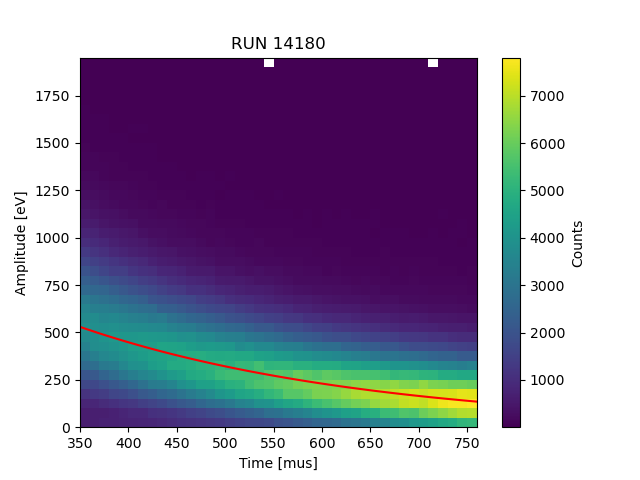

In [ ]:


fig, ax = plt.subplots()

# 2. Mask zero bins
total_hist = np.ma.masked_where(total_hist == 0, total_hist)  # Mask bins where the count is zero

# 3. Create a custom colormap with white for the masked values (zero bins)
cmap = plt.cm.viridis  # Choose a colormap you like
cmap.set_bad(color='white')  # Set masked values (zeros) to white

# 4. Plot the 2D histogram

pcm = ax.pcolormesh(xedges, yedges, total_hist.T, cmap=cmap)

# Add color bar
plt.colorbar(pcm, ax=ax, label='Counts')

plt.xlabel("Time [mus]")
plt.ylabel("Amplitude [eV]")

plt.title(f"RUN {RUN}")


times = np.linspace(350,760, 100)
plt.plot(times, exp_decay(times, 1700, 300), c = "red")

/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_24687/2945947159.py:11: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_bad(color='white')  # Set masked values (zeros) to white


Text(0.5, 1.0, 'RUN 14180')

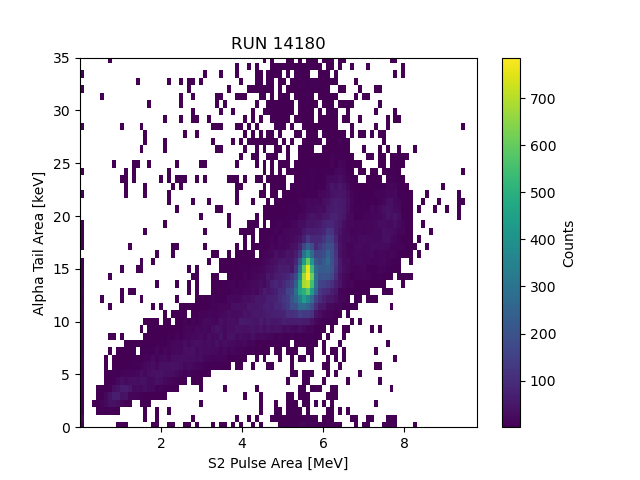

In [ ]:
# energy_per_event = data_copy.groupby(['event'])['pe_intC'].sum().reset_index()
# display(energy_per_event)

hist, xedges2, yedges2 = np.histogram2d(np.array(S2_areas)*PE_to_MeV,np.array(total_energy)/1000, bins=[100, 1000])

# 2. Mask zero bins
masked_hist = np.ma.masked_where(hist == 0, hist)  # Mask bins where the count is zero

# 3. Create a custom colormap with white for the masked values (zero bins)
cmap = plt.cm.viridis  # Choose a colormap you like
cmap.set_bad(color='white')  # Set masked values (zeros) to white

# 4. Plot the 2D histogram
fig, ax = plt.subplots()
pcm = ax.pcolormesh(xedges2, yedges2, masked_hist.T, cmap=cmap)

# Add color bar
plt.colorbar(pcm, ax=ax, label='Counts')

plt.xlabel("S2 Pulse Area [MeV]")
plt.ylabel("Alpha Tail Area [keV]")
plt.ylim(0,35)

plt.title(f"RUN {RUN}")

# plt.plot(S2_arr, Line(S2_arr, 2.5, 0), c = "red")

In [ ]:
# Get the total area 

from scipy.integrate import quad

# Define the parameters
q0 = 1700
Tau = 300

# Define the function
def q(t):
    return q0 * np.exp(-t / Tau)

# Calculate the integral from 0 to 900
integral_value, _ = quad(q, 0, 800)
print(integral_value)


123379.08407281604
